In [1]:
import imagej
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# initialize ImageJ
ij = imagej.init('sc.fiji:fiji:2.14.0') 
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.14.0/1.54f


Crop and save as raw images

In [2]:
def crop_250x_to_1000x(tif):
    original = np.asarray(ij.py.from_java(tif))

    rows = original.shape[0]
    cutoff = int(rows * 0.934)  
    scalebar_free = original[:cutoff, :] #Crop the scalebar away

    lst = []

    new_length = int(np.shape(scalebar_free)[1] / 4)
    new_height = int(np.shape(scalebar_free)[0] / 4)

    for i in range(4):
        for j in range(4):
            lst.append(scalebar_free[i*new_height:new_height*(i+1), j*new_length:new_length*(j+1)])

    return lst

In [3]:
import tifffile as tiff

#imp_lst = [ij.IJ.openImage(p) for p in paths]

folder = Path(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell")

for file in folder.iterdir():
    if file.suffix != ".tif":
        pass
    else:
        for i in range(16):
            file_path = Path(rf"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\raw\{file.stem}_{i}.tif")
            if Path(file_path).exists():
                pass
            else:
                tiff.imwrite(file_path, crop_250x_to_1000x(ij.IJ.openImage(str(file.resolve())))[i])
print("Done!")

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


Done!


Masks

In [4]:
paths = [r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\1m_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\1pm_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\1ps_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\2m_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\2pm_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\2ps_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\3m_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\3pm_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\3ps_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\6m_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\6pm_x250 (1).tif",
         r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\6ps_x250 (1).tif"]

In [5]:
imp_lst = [ij.IJ.openImage(p) for p in paths]
arr_lst = []
for imp in imp_lst:
    ij.IJ.setThreshold(imp, 220, 255)
    ij.IJ.run(imp, "Convert to Mask", "")
    original = np.asarray(ij.py.from_java(imp)).astype(np.uint8)
    imp.close()
    arr_lst.append(original)

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


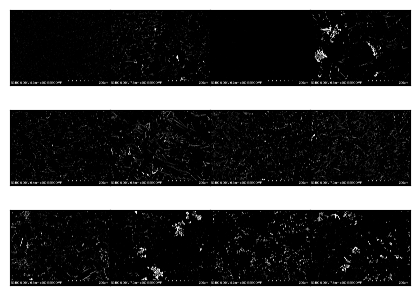

In [19]:
fig, axarr = plt.subplots(3, 4)
flat = axarr.flatten()

for i in range(len(arr_lst)):
    flat[i].imshow(arr_lst[i], cmap = "Greys_r")
    flat[i].set_xticks([])
    flat[i].set_yticks([])

fig.subplots_adjust(left=0,bottom=0, right=1, top=1, hspace=0, wspace=0)

fig.set_figheight(3)
fig.set_figwidth(4)

fig.savefig("12_classes", dpi = 300)

In [23]:
import imageio

def first_mask(chinese_folder_str, save_folder_str):
    chinese_folder = Path(chinese_folder_str)
    save_folder = Path(save_folder_str)
    for file in chinese_folder.iterdir():
        if file.suffix != ".tif":
            pass
        else:
            if Path(save_folder / f"{file.stem}_temp_mask{file.suffix}").exists():
                pass
            else:
                imp = ij.IJ.openImage(str(file.resolve()))
                ij.IJ.setThreshold(imp, 220, 255)
                ij.IJ.run(imp, "Convert to Mask", "")
                array = np.asarray(ij.py.from_java(imp)).astype(np.uint8)
                imp.close()
                array = array / array.max()
                mask = (array * 255).astype(np.uint8)                                                                
                imageio.imwrite(save_folder / f"{file.stem}_temp_mask{file.suffix}", mask)

first_mask(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell", r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\temp_masks")

In [ ]:
from PIL import Image
from scipy import ndimage
import skimage.filters as ski


def clean_binary_mask(path):
    img = Image.open(path)
    arr = np.asarray(img)
    rows = arr.shape[0]
    cutoff = int(rows * 0.934)  
    arr = arr[:cutoff, :]
    gaussian = ski.gaussian(arr, sigma = 5)
    filtered = (gaussian > 0.7).astype(np.uint8)
    label, _ = ndimage.label(filtered)
    counts = np.bincount(label.ravel())
    keep = counts >= 1000
    keep[0] = False
    return keep[label]


def filter_all_chinese(chinese_folder_str, save_folder_str):
    chinese_folder = Path(chinese_folder_str)
    save_folder = Path(save_folder_str)
    for file in chinese_folder.iterdir():
        if file.suffix != ".tif":
            pass
        else:
            if Path(save_folder / f"{file.stem}_temp_mask{file.suffix}").exists():
                pass
            else:
                filtered = clean_binary_mask(file.resolve())
                mask = (filtered * 255).astype(np.uint8)                                                                
                imageio.imwrite(save_folder / f"{file.stem}_temp_mask{file.suffix}", mask)

filter_all_chinese(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell", r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\temp_masks")

Crop masks

In [3]:
import tifffile as tiff

folder = Path(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\clean_masks")

for file in folder.iterdir():
    if file.suffix != ".tif":
        pass
    else:
        for i in range(16):
            file_path = Path(rf"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\label\{file.stem}_{i}.tif")
            if Path(file_path).exists():
                pass
            else:
                tiff.imwrite(file_path, crop_250x_to_1000x(ij.IJ.openImage(str(file.resolve())))[i])
print("Done!")

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


Done!


In [ ]:
from PIL import Image

def upscale_250x_images(folder_path, save_folder_path):
    folder = Path(folder_path)
    save_folder = Path(save_folder_path)

    for file in folder.iterdir():
        img = Image.open(file)

        upscaled_img = img.resize((2560, 1790), Image.Resampling.NEAREST)

        upscaled_img.save(save_folder / f"{file.stem}_upscaled{file.suffix}")

In [15]:
upscale_250x_images(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\raw", r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\dataset_ny_modell2\train\raw")

In [16]:
upscale_250x_images(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\label", r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\dataset_ny_modell2\train\label")

In [21]:
img = Image.open(Path(r"C:\Users\magfa\Documents\Prosjekt\Prosjektbilder\SEM Fe tilsetning og kjølerate\NyModell\dataset_ny_modell2\train\label\6ps_x250 (2)_temp_mask_7_upscaled.tif"))

arr = np.asarray(img)

print(np.unique(arr))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24